# Purpose
- Run suite2p motion correction on online motion correction (OMC) test data
- After splitting planes
## Suite2p env

In [52]:
from pathlib import Path
import tifffile
import json
from ScanImageTiffReader import ScanImageTiffReader
import h5py
import time
from suite2p import default_ops
from suite2p.registration import nonrigid, register


In [55]:
# Split the file into 8 planes
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online motion correction\mouse_721291\test_240509')
data_fn = data_dir / 'global_motioncorrection_1x8_00003.tif'
num_planes = 8

with tifffile.TiffFile(data_fn) as tif:
# with Image.open(data_fn) as img:
    # frames.append(tif.pages[fnum].asarray())
    num_pages = (len(tif.pages))
    # dtype = tif.pages[0].asarray().dtype
    for i in range(num_planes):
        print(f'processing {i}/{num_planes-1}')
        temp_imgs = [tif.pages[ii].asarray() for ii in range(i,num_pages,num_planes)]
        temp_name = data_fn.name.split('.')[0]
        temp_fn = data_fn.parent / f'{temp_name}_{i:02}.h5'
        # tifffile.imwrite(temp_fn, temp_imgs)
        with h5py.File(temp_fn, 'w') as h:
            h.create_dataset('data', data=temp_imgs)
        # with tifffile.TiffWriter(temp_fn, bigtiff=True) as tif:
        #     for image in temp_imgs:
        #         tif.write(image)

processing 0/7
processing 1/7
processing 2/7
processing 3/7
processing 4/7
processing 5/7
processing 6/7


In [ ]:

base_name = data_fn.name.split('.')[0]
for i in range(num_planes):
    ops=default_ops()
    ops['batch_size'] = 1000
    ops['maxregshift'] = 0.2
    ops['snr_thresh'] = 1.2 # Default: 1.2 # if any nonrigid block is below this threshold, it gets smoothed until above this threshold. 1.0 results in no smoothing
    ops['block_size'] = 64
    ops['maxregshiftNR'] = np.round(bs/10) # Default = 5

    fn = data_fn.parent / f'{base_name}_{i:02}.h5'
    t0 = time.time()
    with h5py.File(fn, 'r') as h5:
        imgs = h5['data'][:]
    reg_movie = np.zeros_like(imgs)

    register_result = register.compute_reference_and_register_frames(f_align_in=mc_movie, f_align_out=mc_reg_movie, ops=ops)
    ops['reg_result'] = register_result
    
    temp_fn_base = fn.name.split('.')[0]
    save_fn_h5 = data_fn.parent / f'{temp_fn_base}_reg.h5'
    save_fn_npy = data_fn.parent / f'{temp_fn_base}_ops.npy'
    with h5py.File(save_fn_h5, 'w') as h:
        h.create_dataset(name='data', data=reg_movie)
    np.save(save_fn_npy, ops)
    
    t1 = time.time()
    print(f'{(t1-t0)/60:.1f} min for registering {i}/{num_planes-1}')


In [40]:
data_fn.name.split('.')[0]

'global_motioncorrection_1x8_00003'

In [3]:
def _extract_dict_from_si_string(string):
    """Parse the 'SI' variables from a scanimage metadata string"""

    lines = string.split('\n')
    data_dict = {}
    for line in lines:
        if line.strip():  # Check if the line is not empty
            key, value = line.split(' = ')
            key = key.strip()
            if value.strip() == 'true':
                value = True
            elif value.strip() == 'false':
                value = False
            else:
                value = value.strip().strip("'")  # Remove leading/trailing whitespace and single quotes
            data_dict[key] = value

    json_data = json.dumps(data_dict, indent=2)
    loaded_data_dict = json.loads(json_data)
    return loaded_data_dict

In [28]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online motion correction\mouse_721291\test_240509')
data_fn = data_dir / 'global_motioncorrection_1x8_00003.tif'

with ScanImageTiffReader(str(data_fn)) as reader:
    md_string = reader.metadata()

# split si & roi groups, prep for seprate parse
s = md_string.split("\n{")
rg_str = "{" + s[1]
si_str = s[0]

# parse 1: extract keys and values, dump, then load again
si_metadata = _extract_dict_from_si_string(si_str)
# parse 2: json loads works hurray
roi_groups_dict = json.loads(rg_str)

In [30]:
roi_groups_dict

{'RoiGroups': {'imagingRoiGroup': {'ver': 1,
   'classname': 'scanimage.mroi.RoiGroup',
   'name': 'MROI Imaging ROI Group',
   'UserData': None,
   'roiUuid': 'D13AC8ABC660883F',
   'roiUuiduint64': 1.507658334e+19,
   'rois': {'ver': 1,
    'classname': 'scanimage.mroi.Roi',
    'name': 'ROI 1',
    'UserData': None,
    'roiUuid': '44E502BFBCE444A5',
    'roiUuiduint64': 4.964377187e+18,
    'zs': [19, 67, 109, 143, 195, 233, 277, 307],
    'scanfields': [{'ver': 1,
      'classname': 'scanimage.mroi.scanfield.fields.RotatedRectangle',
      'name': '',
      'UserData': None,
      'roiUuid': '609CFE93C14CBB96',
      'roiUuiduint64': 6.961719035e+18,
      'centerXY': [-7.448734966, -1.580210311],
      'sizeXY': [2.547770701, 2.547770701],
      'rotationDegrees': 0,
      'enable': 1,
      'pixelResolutionXY': [512, 512],
      'pixelToRefTransform': [[0.00497611465, 0, -8.725108374],
       [0, 0.00497611465, -2.856583719],
       [0, 0, 1]],
      'affine': [[2.547770701, 0, 

In [29]:
si_metadata

{'SI.ConfigPageClass': 'dabs.resources.configuration.resourcePages.SIPage',
 'SI.LINE_FORMAT_VERSION': '1',
 'SI.PREMIUM': True,
 'SI.TIFF_FORMAT_VERSION': '4',
 'SI.VERSION_COMMIT': '56c3afc1bf090313ec49069b93dab351ee92fd74',
 'SI.VERSION_MAJOR': '2020',
 'SI.VERSION_MINOR': '1',
 'SI.VERSION_UPDATE': '4',
 'SI.acqState': 'grab',
 'SI.acqsPerLoop': '1',
 'SI.errorMsg': '',
 'SI.extTrigEnable': '0',
 'SI.fieldCurvatureRxs': '[]',
 'SI.fieldCurvatureRys': '[]',
 'SI.fieldCurvatureTilt': '0',
 'SI.fieldCurvatureTip': '0',
 'SI.fieldCurvatureZs': '[]',
 'SI.hBeams.enablePowerBox': False,
 'SI.hBeams.errorMsg': '',
 'SI.hBeams.flybackBlanking': True,
 'SI.hBeams.hBeamRouters': '{}',
 'SI.hBeams.hBeams': "{'Total' 'Split'}",
 'SI.hBeams.hReserver': '[]',
 'SI.hBeams.hUsers': '{}',
 'SI.hBeams.interlaceDecimation': '[1 1]',
 'SI.hBeams.interlaceOffset': '[0 0]',
 'SI.hBeams.lengthConstants': '[Inf Inf]',
 'SI.hBeams.name': 'SI Beams',
 'SI.hBeams.powerBoxEndFrame': 'Inf',
 'SI.hBeams.powerBo

In [7]:
# read one frame of the tif file
frame_nums = range(20)
frames = []
with tifffile.TiffFile(data_fn) as tif:
    for fnum in frame_nums:
        frames.append(tif.pages[fnum].asarray())


In [13]:
import napari
import numpy as np

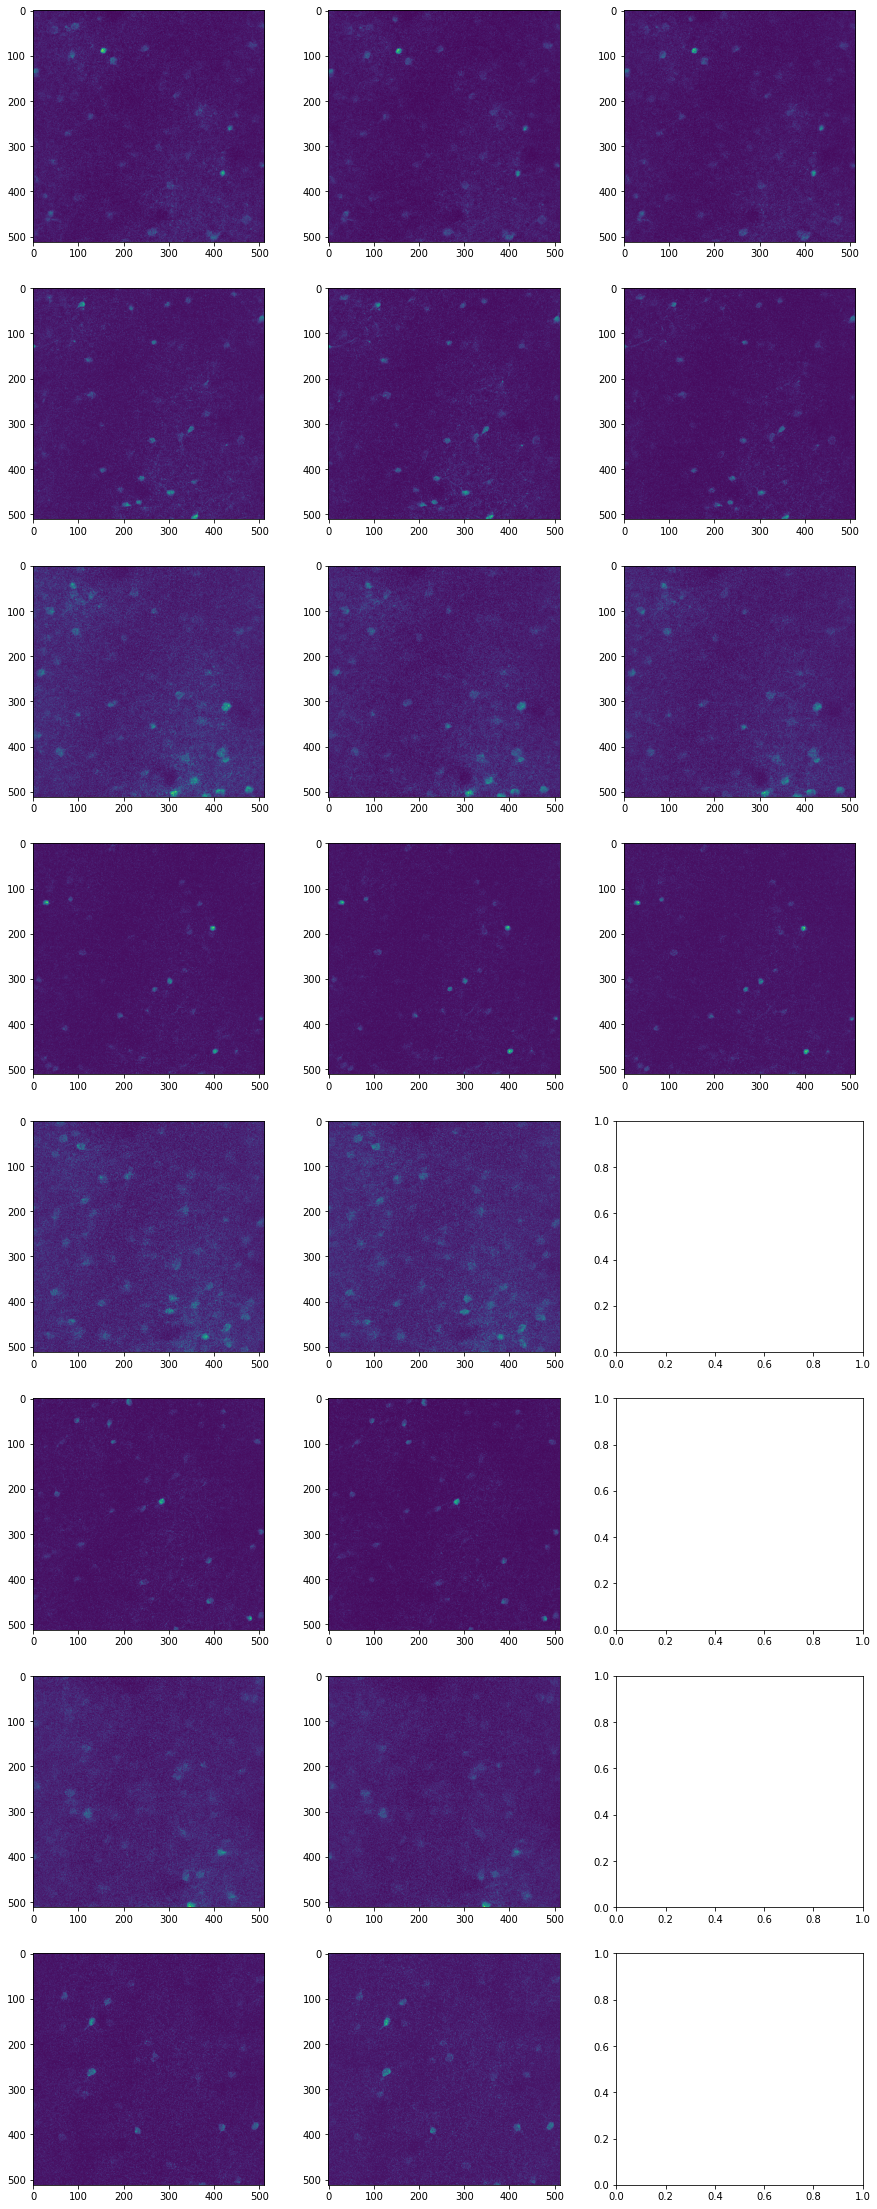

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(8,3, figsize=(15,40))
for i in range(len(frames)):
    axi = i % 8
    axj = i // 8
    ax[axi, axj].imshow(frames[i])

In [23]:
viewer = napari.Viewer()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\jinho.kim\Anaconda3\envs\suite2p\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_16688\1956972150.py", line 1, in <cell line: 1>
    viewer = napari.Viewer()
  File "C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\napari\_lazy.py", line 39, in __getattr__
    from scipy import stats  # noqa: F401
  File "C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\scipy\stats\__init__.py", line 485, in <module>
    from ._stats_py import *
  File "C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py", line 37, in <module>
    from numpy.testing import suppress_warnings
  File "C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\numpy\testing\__init__.py", line 11, in <module>
    from ._private.utils import *
  File "C:\Users\jin